# Projeto 3 - Análise de sentimento sobre o mercado financeiro

## Financial Sentiment Analysis
Este conjunto de dados reúne diversos textos sobre o mercado financeiro e categoriza cada texto em positivo, negativo e neutro.

## Preparação do ambiente
Para este projeto, acessem o [link do dataset](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis) e logo abaixo cliquem em "Download". Caso você não tenha uma conta no Kaggle, crie uma e retorne para esse ponto para realizar o download. Descompacte o arquivo.
Este conjunto de dados está em inglês, use o Spacy e os demais dados auxiliares em inglês.
Caso demore demais para executar ou que ocorra estouro de memória, use somente 40% dos dados.

In [1]:
# upgrade do Spacy - Rodar 1a. vez que carregar e reiniciar o runtime
!pip install --upgrade spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# rodar apenas 1a. vez e não é necessário reiniciar o runtime
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 4.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [6]:
df = pd.read_csv('./data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [7]:
df.sample(10)

,Sentence,Sentiment
493,The sale price was not disclosed .,neutral
1231,Outotec 's scope of delivery covers the engine...,neutral
2422,Capital base and capital adequacy measurement ...,neutral
709,Retailers Kingfisher and Sports Direct rise in...,positive
2192,The Commission is to be applauded for applying...,positive
5693,`` This could be us .,neutral
4348,Swedish telco TeliaSonera is teaming up with F...,neutral
1907,Based on strong customer interest and feedback...,positive
1656,@1nvestor: $SODA has a 42.71% Float Short. LoL...,negative
3136,"`` Overall , we 're pleased with the startup c...",positive


In [8]:
df.count()

Sentence     5842
Sentiment    5842
dtype: int64

In [9]:
df.shape

(5842, 2)

In [10]:
df.columns

Index(['Sentence', 'Sentiment'], dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


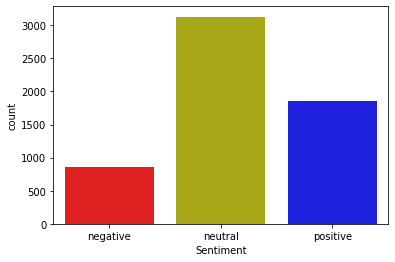

In [12]:
sns.countplot(data=df, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

###1- Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro. Quais foram os valores de acurácia, precisão e sensitividade deste modelo? (3.0 pontos)

In [13]:
# classe para gerenciar X e y
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Esta funcao remove espacos em branco no inicio e
# no fim do texto e converte todo o texto em letras
# minusculas
def clean_text(texto):     
    return texto.strip().lower()

# Esta funcao remove todas as stopwords e pontuacoes
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

# vetorizador de textos
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1)) 

# modelo SVM
classifier = SVC()

In [14]:
# Separando em X e y
X = df.Sentence
y = df.Sentiment

# Separando em teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Construindo uma pipeline
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

**R:** Acurácia, precisão e sensibilidade na saída da célula abaixo.

In [16]:
print('Acurácia: ', round(accuracy, 4))
print('Precisão: ', round(precision, 4))
print('Sensitividade', round(recall, 4))

Acurácia:  0.6784
Precisão:  0.5832
Sensitividade 0.5243


In [17]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'),
             columns = ['Pred_Negative', 'Pred_Neutral', 'Pred_Positive'], index = ['Negative', 'Neutral', 'Positive'])
cm

,Pred_Negative,Pred_Neutral,Pred_Positive
Negative,0.104046,0.693642,0.202312
Neutral,0.055205,0.894322,0.050473
Positive,0.011050,0.414365,0.574586


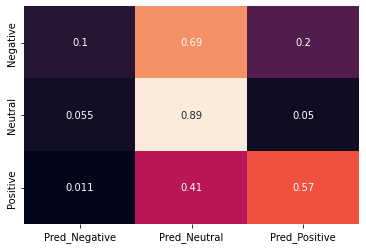

In [19]:
sns.heatmap(data=cm, annot=True, cbar=False);

### 2- Use o seu modelo para classificar os seguintes textos extraídos do site [Financial Times](https://www.ft.com/). Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir? (1.0 ponto)

* Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety. resultado esperado: [negativo]
* China opens up bond market in bid to woo foreign investors. resultado esperado: [neutro]
* HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this. resultado esperado: [negativo]
* Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism. resultado esperado: [negativo]
* Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate. resultado esperado: [neutro]

Os trechos de textos foram colocados em um arquivo csv chamado 'data_ft.csv', configurado em uma tabela com as colunas:

* "Sentence": o trecho de texto a ser analisado;
* "Sentiment": o sentimento esperado.

In [20]:
df_ft = pd.read_csv('./data_ft.csv', delimiter=';')
df_ft

,Sentence,Sentiment
0,"Central banks’ rate rises, geopolitical risk a...",negative
1,China opens up bond market in bid to woo forei...,neutral
2,HM Revenue & Customs says residents had £850bn...,negative
3,Japan’s horrifying crop of data falsification ...,negative
4,"Despite internal problems, the group continues...",neutral


In [21]:
df_ft.columns

Index(['Sentence', 'Sentiment'], dtype='object')

In [22]:
df_ft.Sentiment.unique()

array(['negative', 'neutral'], dtype=object)

In [23]:
X_ft = df_ft.Sentence
y_ft = df_ft.Sentiment

In [24]:
y_ft_pred = pipe.predict(X_ft)

In [25]:
accuracy_ft = accuracy_score(y_ft, y_ft_pred)
precision_ft = precision_score(y_ft, y_ft_pred, average='macro')
recall_ft = recall_score(y_ft, y_ft_pred, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print(round(accuracy_ft,4))
print(round(precision_ft,4))
print(round(recall_ft,4))

0.4
0.1667
0.3333


In [27]:
cm_ft = pd.DataFrame(confusion_matrix(y_ft, y_ft_pred),
             columns = ['Pred_Negative', 'Pred_Neutral', 'Pred_Positive'], index = ['Negative', 'Neutral', 'Positive'])
cm_ft

,Pred_Negative,Pred_Neutral,Pred_Positive
Negative,0,2,1
Neutral,0,2,0
Positive,0,0,0


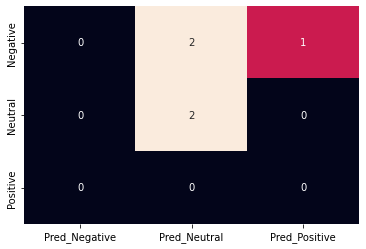

In [28]:
sns.heatmap(data=cm_ft, annot=True, cbar=False);

**R:** Houve divergência entre 2 predições cujas classificações foram neutras mas que eram na verdade negativas e uma que deveria ser negativa e que foi predita positiva.

A princípio, o maior problema do modelo é o desbalanceamento dos dados de treino, pois temos 3130 frases para sentimento neutro, 1852 para positivo e 860 negativos. Por este motivo, acredito que os dados de treino precisam ser mais balanceados como números mais próximos. Precisaríamos de mais dados, mas podemos levantar um hipótese de que há uma tendência para classificação das notícias para o neutro.

Poderíamos trocar o classificador, mas acredito que não obteríamos resultados significativamente melhores.

Uma hipótese mais tangível, seria pegar um subset de conjuntos de classe negativa, positiva e neutra com número de observações iguais e ver como o modelo de aprendizado se comporta.

A seguir a tabela com a contagem de frases para cada sentimento e logo após, um gráfico cujas barras representam a tabela.

In [29]:
df.groupby('Sentiment').count()

,Sentence
Sentiment,
negative,860
neutral,3130
positive,1852


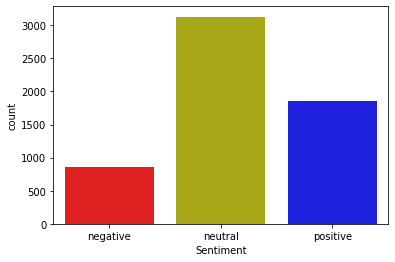

In [30]:
sns.countplot(data=df, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

Vamos tirar amostras com o mesmo número de observações de classificação negativa.

In [31]:
df_pos = df.loc[ df['Sentiment']=='positive' ].sample(len(df.loc[ df['Sentiment']=='negative' ]))

In [32]:
df_neu = df.loc[ df['Sentiment']=='neutral' ].sample(len(df.loc[ df['Sentiment']=='negative' ]))

In [33]:
df_neg = df.loc[ df['Sentiment']=='negative' ] 

Juntando as tabelas

In [34]:
df_new = df_pos.append(df_neu).append(df_neg)

Embaralhando:

In [35]:
df_new = df_new.sample(3 * len(df.loc[ df['Sentiment']=='negative' ]))

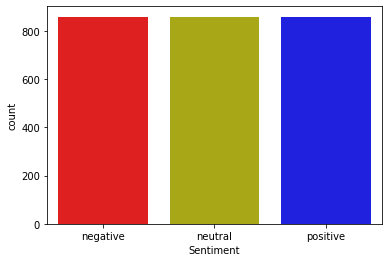

In [36]:
sns.countplot(data=df_new, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

Novo treinamento:

In [37]:
X = df_new.Sentence
y = df_new.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

In [38]:
accuracy_new = accuracy_score(y_test, y_pred)
precision_new = precision_score(y_test, y_pred, average='macro')
recall_new = recall_score(y_test, y_pred, average='macro')

Com dados balanceados, o desempenho do modelo de uma maneira geral diminui. A acurácia cai consideravelmente, mas nota-se que a precisão e a sensitividade aumentam levemente, provavelmente pelo fato do modelo ficar com menos viés para o neutro.

A seguir, os valores e matrizes de confusão:

In [43]:
print(f'Acurácia_new: {round(accuracy_new, 4)}          Acurácia_old: {round(accuracy, 4)}')
print(f'Precisão_new: {round(precision_new, 4)}         Precisão_old: {round(precision, 4)}')
print(f'Sensitividade_new: {round(recall_new, 4)}    Sensitividade_old: {round(recall, 4)}')

Acurácia_new: 0.595          Acurácia_old: 0.6784
Precisão_new: 0.6234         Precisão_old: 0.5832
Sensitividade_new: 0.5962    Sensitividade_old: 0.5243


In [45]:
cm_new = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='true'),
             columns = ['Pred_Negative', 'Pred_Neutral', 'Pred_Positive'], index = ['Negative', 'Neutral', 'Positive'])
cm_new

,Pred_Negative,Pred_Neutral,Pred_Positive
Negative,0.602273,0.289773,0.107955
Neutral,0.184524,0.767857,0.047619
Positive,0.203488,0.377907,0.418605


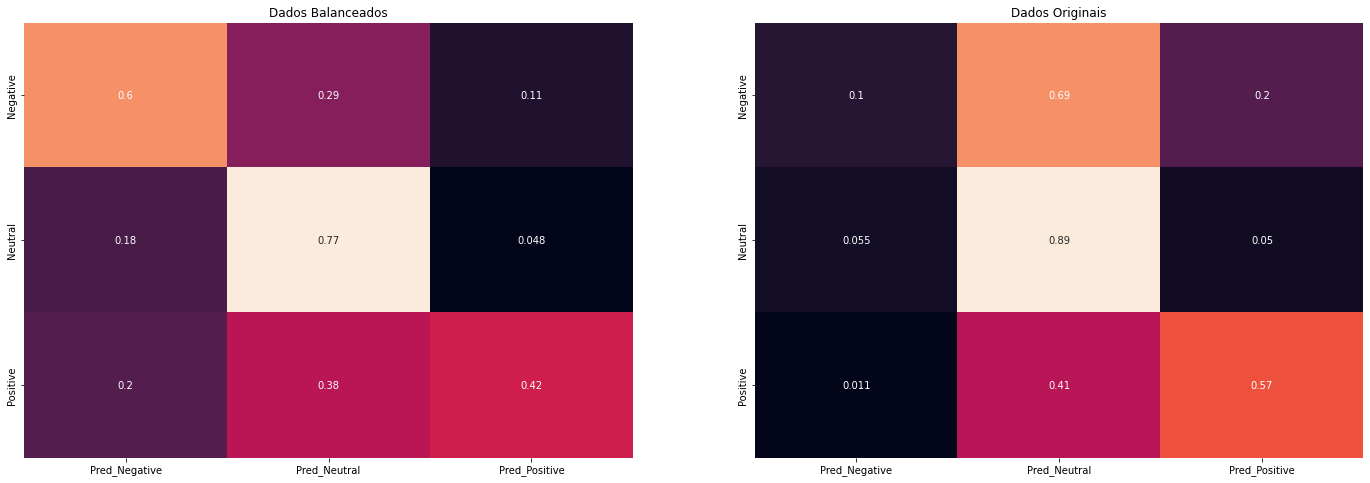

In [55]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
sns.heatmap(data=cm_new, annot=True, cbar=False)
plt.title('Dados Balanceados')

plt.subplot(1, 2, 2)
sns.heatmap(data=cm, annot=True, cbar=False)
plt.title('Dados Originais');

###3- Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. (3.0 pontos)
a. Extraia de todos os textos as entidades, há quantas entidades? (0.6 pontos) 

b. Quantas entidades são empresas? (0.6 pontos)

c. Quais são as três empresas mais citadas? (0.6 pontos)

d. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma. (1.2 pontos)

In [56]:
def get_ent(data_frame, text_col, sent_col):
    ents = []
    labels = []
    sents = []
    idx_original = []
    
    for i in range(len(data_frame)):
        text = clean_text(data_frame[text_col][i])
        doc = nlp(text)
        
        for ent in doc.ents:
            ents.append(ent.text)
            labels.append(ent.label_)
            sents.append(data_frame[sent_col][i])
            idx_original.append(i)
    
    return pd.DataFrame({
        'Entity': ents, 
        'Labels': labels, 
        'Sentiment': sents, 
        'idx_original': idx_original
        })

In [57]:
entities = get_ent(df, 'Sentence', 'Sentiment')

In [58]:
entities

,Entity,Labels,Sentiment,idx_original
0,the geosolutions technology,ORG,positive,0
1,esi,ORG,negative,1
2,$1.50 to $2.50,MONEY,negative,1
3,the last quarter of 2010,DATE,positive,2
4,componenta,ORG,positive,2
...,...,...,...,...
12615,eu,ORG,neutral,5839
12616,22.5 %,PERCENT,neutral,5840
12617,helsinki afx - kci konecranes,ORG,positive,5841
12618,four,CARDINAL,positive,5841


**a.) R: Conforme a saída da célula abaixo, há 5867 entidades:**

In [61]:
len(entities['Entity'].unique())

5867

In [62]:
entities.Entity.value_counts()

finnish              358
finland              309
today                191
2009                 145
2007                 136
                    ... 
ipad                   1
about twenty           1
peter wiklof           1
up to 20 km            1
bhushan steel and      1
Name: Entity, Length: 5867, dtype: int64

**b.) R:Conforme a saída da célula abaixo, há 2519 entidades com a label ORG, ou seja, classificadas como empresas:**

In [63]:
len(entities.loc[ entities['Labels'] == 'ORG' ])

2519

In [64]:
entities.loc[ entities['Labels'] == 'ORG' ]['Entity'].value_counts()[0:5]

nokia         60
finnair       30
tesco         29
stora enso    21
aapl          21
Name: Entity, dtype: int64

**c.) As três empresas mais citadas:**

In [65]:
org = entities.loc[entities['Labels'] == 'ORG']['Entity'].value_counts().sort_values(ascending=False)[0:3].index
org

Index(['nokia', 'finnair', 'tesco'], dtype='object')

**d.) R: Tabelas a seguir:**

In [66]:
df_buffer = entities.loc[ (entities['Labels'] == 'ORG') & ((entities['Entity'] == org[0]) | (entities['Entity'] == org[1]) | (entities['Entity'] == org[2])) ]
df_buffer.head()

,Entity,Labels,Sentiment,idx_original
102,nokia,ORG,positive,44
124,tesco,ORG,positive,53
201,tesco,ORG,negative,91
323,finnair,ORG,negative,146
335,nokia,ORG,neutral,151


**Tabela da empresa mais citada: Nokia**

In [67]:
df_first = df_buffer.loc[ (entities['Entity'] == org[0]) & (entities['Labels'] == 'ORG') ]
df_first.groupby(['Sentiment'])[['Entity']].count().reset_index()

,Sentiment,Entity
0,negative,5
1,neutral,35
2,positive,20


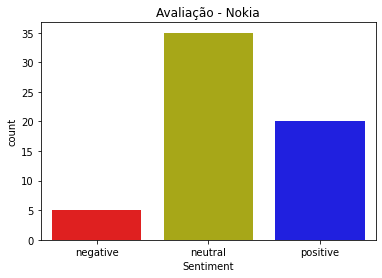

In [68]:
plt.title(f'Avaliação - {org[0].capitalize()}')
sns.countplot(data=df_first, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

**Tabela da segunda empresa mais citada: Finnair**

In [69]:
df_second = df_buffer.loc[ (entities['Entity'] == org[1]) & (entities['Labels'] == 'ORG') ]
df_second.groupby(['Sentiment'])[['Entity']].count().reset_index()

,Sentiment,Entity
0,negative,8
1,neutral,12
2,positive,10


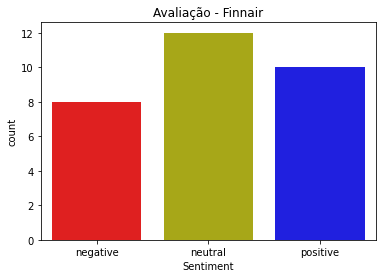

In [70]:
plt.title(f'Avaliação - {org[1].capitalize()}')
sns.countplot(data=df_second, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

**Tabela da terceira empresa mais citada: Tesco**

In [71]:
df_third = df_buffer.loc[ (entities['Entity'] == org[2]) & (entities['Labels'] == 'ORG') ]
df_third.groupby(['Sentiment'])[['Entity']].count().reset_index()

,Sentiment,Entity
0,negative,11
1,neutral,3
2,positive,15


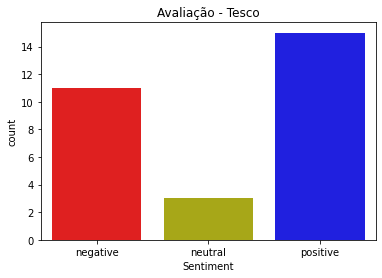

In [72]:
plt.title(f'Avaliação - {org[2].capitalize()}')
sns.countplot(data=df_third, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

###4- Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas. (3.0 pontos)

## Nokia

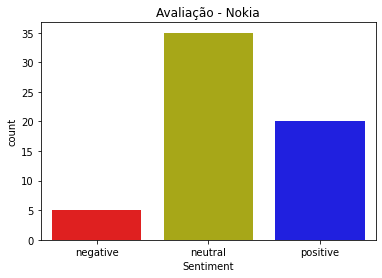

In [73]:
plt.title(f'Avaliação - {org[0].capitalize()}')
sns.countplot(data=df_first, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

### Prezados diretores da Nokia,

Através de uma análise de sentimento usando técnicas de aprendizado de máquina sobre o dataset fornecido, conseguimos identificar um total de 5 notícias negativas (vermelho), 35 neutras (amarelo) e 20 positivas (positivas) sobre a empresa.

Através desse números, é possível afirmar que o sentimento geral do mercado acerca da empresa é neutra, tendendo ao positivo.

Em anexo, duas amostras de cada classificação.

Att,
_____

**Anexo**

In [74]:
idx = df_first.loc[ df_first['Sentiment'] == 'negative' ].sample(2).idx_original
df.loc[idx, 'Sentence']

1665    Nokia 's share price fell less than one percen...
5346    Chief executive officer Olli-Pekka Kallasvuo '...
Name: Sentence, dtype: object

In [75]:
idx = df_first.loc[ df_first['Sentiment'] == 'neutral' ].sample(2).idx_original
df.loc[idx, 'Sentence']

4957    It is being developed by Symbian , the softwar...
3738    Nokia shares hit 13.21 euros on Friday , down ...
Name: Sentence, dtype: object

In [76]:
idx = df_first.loc[ df_first['Sentiment'] == 'positive' ].sample(2).idx_original
df.loc[idx, 'Sentence']

44     A portion , $ 12.5 million , will be recorded ...
685    Nokia was up 0.12 pct to 16.70 eur after kicki...
Name: Sentence, dtype: object

## Finnair

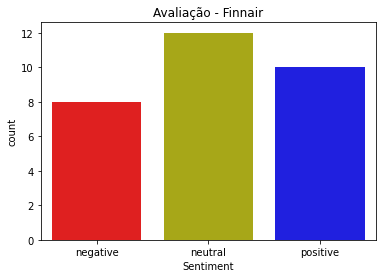

In [77]:
plt.title(f'Avaliação - {org[1].capitalize()}')
sns.countplot(data=df_second, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

### Prezada Diretoria da Finnair

Através de uma análise de sentimento usando técnicas de aprendizado de máquina sobre o dataset fornecido, conseguimos identificar um total de 8 notícias negativas (vermelho), 12 neutras (amarelo) e 10 positivas (azul) sobre a empresa.

É possível notar que número de negativas, positivas e neutras estão muito próximos. Por este motivo, o sentimento em relação a empresa é muito difuso entre essas três classificações, não possibilitando ums classificação de sentimento geral.

Em anexo, duas amostras de cada notícia clasificada nas três características.

Att,
_____

**Anexos**

In [78]:
idx = df_second.loc[ df_second['Sentiment'] == 'negative' ].sample(2).idx_original
df.loc[idx, 'Sentence']

1165    During the strike , Finnair estimates to incur...
1950    Finnish airline Finnair is starting the tempor...
Name: Sentence, dtype: object

In [79]:
idx = df_second.loc[ df_second['Sentiment'] == 'neutral' ].sample(2).idx_original
df.loc[idx, 'Sentence']

3713    Jukka Hienonen , the current Finnair CEO , wil...
4507    According to Tyrv+ñinen 's estimation , Japan ...
Name: Sentence, dtype: object

In [80]:
idx = df_second.loc[ df_second['Sentiment'] == 'positive' ].sample(2).idx_original
df.loc[idx, 'Sentence']

4427    Efficiency programs totalling 100 million euro...
700     `` We reached agreement with the union that fl...
Name: Sentence, dtype: object

## Tesco

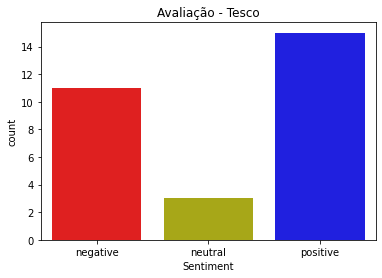

In [81]:
plt.title(f'Avaliação - {org[2].capitalize()}')
sns.countplot(data=df_third, x='Sentiment', order=['negative', 'neutral', 'positive'], palette=['r', 'y', 'b']);

### Prezados Srs.
Através de uma análise de sentimento usando técnicas de aprendizado de máquina sobre o dataset fornecido, conseguimos identificar um total de 11 notícias negativas, 3 neutras e 15 positivas sobre a empresa.

Muito embora haja muitas notícias positivas, o número de negativas é muito significativa, resultando em um sentimento polarizado pela empresa por parte do mercado financeiro.

Em anexo, duas amostras de cada notícia clasificada nas três características.

Att,
____

## Anexo

In [82]:
idx = df_third.loc[ df_third['Sentiment'] == 'negative' ].sample(2).idx_original
df.loc[idx, 'Sentence']

91     Tesco share price down as grocer faces SFO inv...
713                    Tesco's Sales Pickup Isn't Enough
Name: Sentence, dtype: object

In [83]:
idx = df_third.loc[ df_third['Sentiment'] == 'neutral' ].sample(2).idx_original
df.loc[idx, 'Sentence']

3008    Tesco sells half of stake in ecommerce site La...
923     Despite sales growth, UK's Tesco cautions reco...
Name: Sentence, dtype: object

In [84]:
idx = df_third.loc[ df_third['Sentiment'] == 'positive' ].sample(2).idx_original
df.loc[idx, 'Sentence']

4915    Tesco share price closes higher as two more di...
2670    Tesco sells Blinkbox and broadband service to ...
Name: Sentence, dtype: object